In [45]:
# Problem: after combine_firn_lid a lake never forms again, despite warm air temperaures 
# Reasons:  
#       1. Firn surf temp is never calculated after combine_lid_firn
#           if not cell["exposed_water"] and not cell["saturation"][0]:
#               - call firn_column
#           - This is because cell["saturation"][0] = 1 i.e. surface layer of firn is always saturated  
#           Fix: Allow firn surf temp to be calcuated if top layer is saturated  
#    
#        2. Input fresh temp is set to -13.5oC 
#            Fix: Input T_snow = T_air if < 273.15 else T_snow = 273.15   
# 
# Questions: Are these bug fixes okay ?
#            Is the saturation flag being calculated correctly ? 
#            In combine_firn_lid saturation flag is calculated by interpolating saturation flags for lid (ones) 
#            and saturation of firn (ones or zeros). But this can lead to incorrect logic
#            cell['Sfrac'][0] = 0.3, cell['Lfrac'][0] = 0, cell["saturation"][0] = 1        

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import pandas as pd
import matplotlib.dates as mdates

expt_id = 'era5_2013_2024_19'
start_time = pd.Timestamp('2013-01-01 00:00')

output_filepath = dirPath + '1d_testcase_output_' + expt_id + '.nc' 
met_filepath    = dirPath + '1d_testcase_met_'+ expt_id + '.nc'
dump_filepath   = dirPath + '1d_testcase_dump_' + expt_id  + '.nc' 

met = nc.Dataset(met_filepath, 'r')
output = nc.Dataset(output_filepath, 'r')
dump = nc.Dataset(dump_filepath, 'r')

In [55]:
vertical_depth = dump.variables['vertical_profile'][0:,0, :]
vertical_depth = vertical_depth.squeeze() 

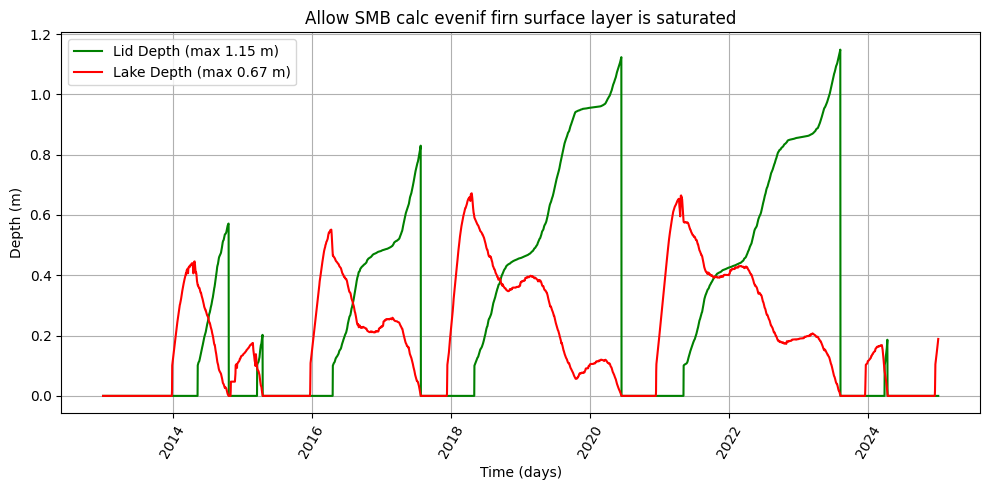

In [56]:
time_day = pd.date_range(start=start_time, periods=len(output.variables['lake_depth'][:, 0, 0]), freq='d')

lid_depth = output.variables['lid_depth'][:, 0, 0]
lake_depth = output.variables['lake_depth'][:, 0, 0]

plt.figure(figsize=(10, 5))
plt.plot(time_day, lid_depth, label=f'Lid Depth (max {lid_depth.max():.2f} m)', color='green')
plt.plot(time_day, lake_depth, label=f'Lake Depth (max {lake_depth.max():.2f} m)', color='red')
plt.xlabel('Time (days)')
plt.ylabel('Depth (m)')
plt.title('Allow SMB calc evenif firn surface layer is saturated')
plt.grid(True)
plt.legend()
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

lake_max = output.variables['lake_depth'][:, 0, 0].max()
lid_max = output.variables['lid_depth'][:, 0, 0].max()


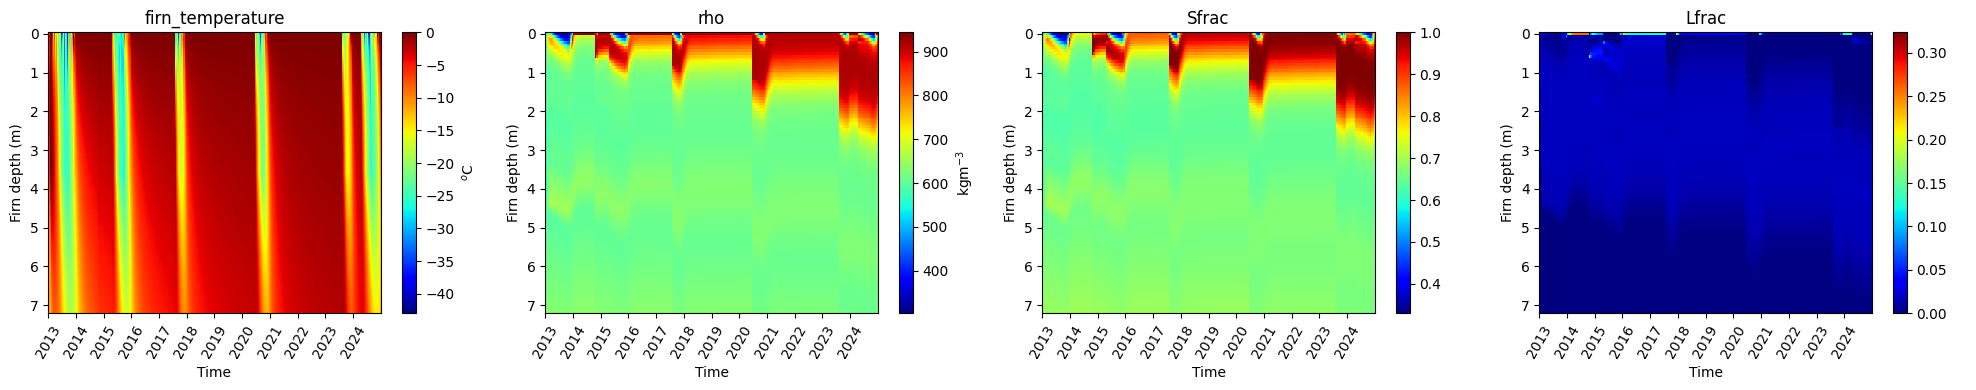

In [57]:
# 2d variables
firn_2d_vars  = ['firn_temperature', 'rho',     'Sfrac', 'Lfrac' ]
firn_2d_units = ['$^{o}$C',          'kgm$^{-3}$', ' ', ' ' ]
firn_2d_min   = [-30,                 300,      0,      0] 
firn_2d_max   = [0,                   1000,     1,      1]  

start_plot = pd.Timestamp('2016-01-01')
end_plot = pd.Timestamp('2016-03-31')

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
axes = axes.flatten()

# check when/if a lake is formed
lake = output.variables['lake'][:, 0, 0]


time_day = pd.date_range(start=start_time, periods=len(lake)-1, freq='d')

for i, var_name in enumerate(firn_2d_vars):
    ax = axes[i]
    data_2d = output.variables[var_name][1:, 0, 0, :]  # skip timestep 0 because of netCDF bug
    
    if var_name == 'firn_temperature': data_2d -= 273.15
    #im = ax.pcolormesh(time_day, vertical_depth, data_2d.T, shading='auto', 
    #                   cmap='jet')#, vmin=firn_2d_min[i],vmax=firn_2d_max[i])
    
    im = ax.pcolormesh(time_day, vertical_depth[0:100], data_2d.T[0:100,:], shading='auto', 
                       cmap='jet')#, vmin=firn_2d_min[i],vmax=firn_2d_max[i])
    
    plt.colorbar(im, ax=ax, label=firn_2d_units[i])
    ax.set_title(var_name)
    ax.set_xlabel('Time')
    ax.set_ylabel('Firn depth (m)')
    ax.invert_yaxis()
    ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=60)

plt.tight_layout()
plt.show()

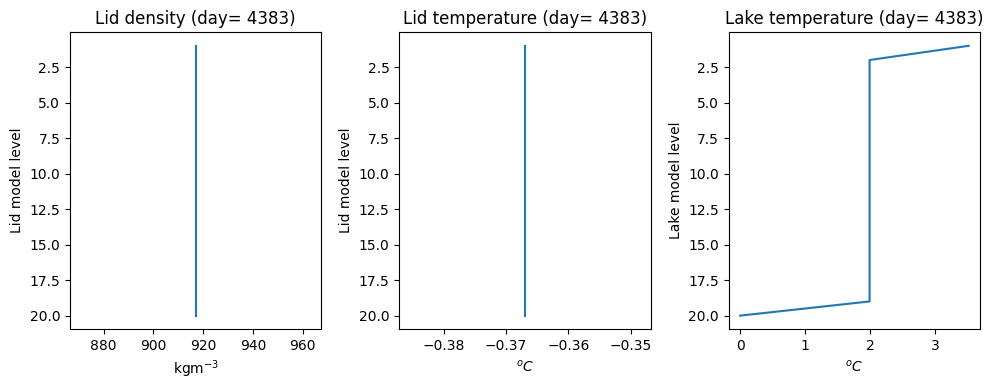

In [58]:
n_days = 4383
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
axes = axes.flatten()

vertical_grid_lid = int(dump.variables['vert_grid_lid'][:])
vertical_grid_lake = int(dump.variables['vert_grid_lake'][:])
rho_lid = dump.variables['rho_lid'][0,0,:]    
lid_temperature = dump.variables['lid_temperature'][0,0,:] 
lake_temperature = dump.variables['lake_temperature'][0,0,:] 


ax = axes[0]
ax.plot(rho_lid, range(1, vertical_grid_lid + 1) )
ax.set_title(f'Lid density (day= {n_days})')
ax.set_xlabel('kgm$^{-3}$')
ax.set_ylabel('Lid model level')
ax.invert_yaxis()  

ax = axes[1]
ax.plot(lid_temperature-273.15, range(1, vertical_grid_lid + 1) )
ax.set_title(f'Lid temperature (day= {n_days})')
ax.set_xlabel('$^{o}C$')
ax.set_ylabel('Lid model level')
ax.invert_yaxis()  

ax = axes[2]
ax.plot(lake_temperature-273.15, range(1, vertical_grid_lake + 1) )
ax.set_title(f'Lake temperature (day= {n_days})')
ax.set_xlabel('$^{o}C$')
ax.set_ylabel('Lake model level')
ax.invert_yaxis()  

plt.tight_layout()
plt.show()

In [59]:
met.close()
output.close()
dump.close()
